In [326]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from statistics import mean
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor

In [327]:
train = pd.read_csv(r'C:\Users\Krutarth\Desktop\Datasets\zindi_solarprice\Train.csv')
metadata = pd.read_csv(r'C:\Users\Krutarth\Desktop\Datasets\zindi_solarprice\metadata.csv')

C:\Users\Krutarth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [328]:
for i in range(0,len(train)):
    train.TransactionDates[i] = [x.strip().replace("'",'').replace('[','').replace(']','') for x in train.TransactionDates[i].split(',')] 

for i in range(0,len(train)):
    train.PaymentsHistory[i] = [float(x.strip().replace("'",'').replace('[','').replace(']','')) for x in train.PaymentsHistory[i].split(',')]

In [329]:
train.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6'],
      dtype='object')

In [330]:
#what i want to know:
#are all ids in train present in metadata? yes
#how do combine the 6 cols
#how do i convert transactiondates and paymenthistory to single value cols
#which cols in metadata are useful

In [331]:
metadata.head()

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35,2016-10-23 04:52:30
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03,2020-05-24 15:32:18
2,ID_102CV85,2015-12-18 00:00:00,2000,2018-03-29 10:14:58,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34,2017-02-01 15:23:44
3,ID_HXBJFHB,2015-11-25 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,43.0,NaN,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57,2017-05-22 16:46:54
4,ID_3K9VZ5J,2015-12-02 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32,2017-05-12 16:50:52


In [332]:
#idea:
#we will use m1...m6 to approximate a function and then use the coeffecients of these functions as the target

In [333]:
month_pred = train[['m1', 'm2', 'm3', 'm4','m5', 'm6']]

In [334]:
coeff_data = pd.DataFrame(columns=['c5','c4','c3','c2','c1','c0'],index=range(0,len(train)))
coefficients = []
for i in range(0,len(train)):
    coefficients.append(np.polyfit(range(1,7),month_pred.iloc[i,:],5))

In [335]:
for i in range(0,len(train)):
    coeff_data.iloc[i,:] = coefficients[i]

In [336]:
coeff_data

,c5,c4,c3,c2,c1,c0
0,43.7917,-761.458,4958.13,-14896,20095.6,-8560
1,7.20038e-14,-1.07727e-12,27.5,-302.5,990,-55
2,-12.5,206.25,-1233.33,3143.75,-2854.17,1450
3,-10.8333,165.417,-996.667,3029.58,-4357.5,2750
4,9.08333,-149.583,948.75,-2960.42,4602.17,-2410
...,...,...,...,...,...,...
28002,-114.75,1972.92,-12649.6,37194.6,-49163.2,24400
28003,-4.41667,32.9167,82.9167,-1097.92,2406.5,-520
28004,5.25833,-71.625,269.958,-22.875,-1129.72,1629
28005,-5.20833,101.458,-765.208,2718.54,-4404.58,3655


In [337]:
metadata.drop(columns=['RegistrationDate'], inplace=True)

In [338]:
metadata.head()

,ID,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
0,ID_K00S4N4,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35,2016-10-23 04:52:30
1,ID_6L67PAA,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03,2020-05-24 15:32:18
2,ID_102CV85,2000,2018-03-29 10:14:58,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34,2017-02-01 15:23:44
3,ID_HXBJFHB,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,43.0,NaN,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57,2017-05-22 16:46:54
4,ID_3K9VZ5J,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32,2017-05-12 16:50:52


In [339]:
#columns to take care of:
'''
UpsellDate           
PaymentMethod  
rateTypeEntity  
MainApplicantGender
Region -- will do after merge
Town 
Occupation -- will do after merge
SupplierName 
ExpectedTermDate  
FirstPaymentDate   
LastPaymentDate      
'''

'\nUpsellDate           \nPaymentMethod  \nrateTypeEntity  \nMainApplicantGender\nRegion -- will do after merge\nTown \nOccupation -- will do after merge\nSupplierName \nExpectedTermDate  \nFirstPaymentDate   \nLastPaymentDate      \n'

In [340]:
metadata.drop(columns=['UpsellDate'], inplace=True)

In [341]:
metadata.drop(columns=['PaymentMethod'], inplace=True)

In [342]:
metadata.drop(columns=['rateTypeEntity'], inplace=True)

In [343]:
metadata.MainApplicantGender.replace({
    'Male':0,
    'Female':1
}, inplace=True)

In [344]:
metadata.Region.value_counts()

Nyanza                6998
North Rift            5344
Nairobi Region        5056
South Rift            4759
Coast Region          4671
Western               4508
Mount Kenya Region    4073
Name: Region, dtype: int64

In [345]:
metadata.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
0,ID_K00S4N4,2000,0.0,35,7,0,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35,2016-10-23 04:52:30
1,ID_6L67PAA,2000,0.0,35,7,0,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03,2020-05-24 15:32:18
2,ID_102CV85,2000,35.0,35,7,1,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34,2017-02-01 15:23:44
3,ID_HXBJFHB,2000,0.0,35,7,1,43.0,NaN,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57,2017-05-22 16:46:54
4,ID_3K9VZ5J,2000,0.0,35,7,1,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32,2017-05-12 16:50:52


In [346]:
metadata.Occupation.value_counts()

Business                  12380
Farmer                    11747
Labourer                   5228
Other                      2770
Driver/Motorbike Rider     2384
Teacher                    1830
Government Employee        1004
Name: Occupation, dtype: int64

In [347]:
metadata.columns

Index(['ID', 'Deposit', 'AccessoryRate', 'RatePerUnit', 'DaysOnDeposit',
       'MainApplicantGender', 'Age', 'Region', 'Town', 'Occupation',
       'SupplierName', 'Term', 'TotalContractValue', 'ExpectedTermDate',
       'FirstPaymentDate', 'LastPaymentDate'],
      dtype='object')

In [348]:
train['mean_payment'] = train[['m1', 'm2', 'm3', 'm4','m5', 'm6']].apply(lambda x: x.mean(), axis=1)

In [349]:
metadata.drop(columns='SupplierName', inplace=True)

In [350]:
metadata.ExpectedTermDate

0        2016-12-08 00:00:00
1        2016-12-07 00:00:00
2        2017-01-13 00:00:00
3        2016-11-23 00:00:00
4        2016-11-30 00:00:00
                ...         
37338    2020-10-17 18:26:52
37339    2020-10-17 18:30:59
37340    2021-01-25 18:42:26
37341    2020-10-17 18:46:30
37342    2020-10-17 19:30:43
Name: ExpectedTermDate, Length: 37343, dtype: object

In [351]:
metadata['ExpectedTermDate'] = pd.to_datetime(metadata['ExpectedTermDate'])

In [352]:
metadata['FirstPaymentDate'] = pd.to_datetime(metadata['FirstPaymentDate'])

In [353]:
metadata['LastPaymentDate'] = pd.to_datetime(metadata['LastPaymentDate'])

In [354]:
metadata['expected_time'] = metadata.ExpectedTermDate - metadata.FirstPaymentDate

In [355]:
metadata['expected_time'] = metadata.expected_time.dt.days

In [356]:
metadata['observed_time'] = metadata.LastPaymentDate - metadata.FirstPaymentDate

In [357]:
metadata['observed_time'] = metadata.observed_time.dt.days

In [358]:
metadata.drop(columns=['ExpectedTermDate','FirstPaymentDate', 'LastPaymentDate'], inplace=True)

In [359]:
metadata.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,Term,TotalContractValue,expected_time,observed_time
0,ID_K00S4N4,2000,0.0,35,7,0,41.0,Mount Kenya Region,Embu,Other,364,14740.0,363,317
1,ID_6L67PAA,2000,0.0,35,7,0,33.0,Coast Region,Kilifi,Other,364,14740.0,363,1628
2,ID_102CV85,2000,35.0,35,7,1,48.0,Nairobi Region,Makueni,Business,392,29480.0,391,411
3,ID_HXBJFHB,2000,0.0,35,7,1,43.0,NaN,UNKNOWN,Teacher,364,14740.0,363,544
4,ID_3K9VZ5J,2000,0.0,35,7,1,56.0,Mount Kenya Region,Kirinyaga,Other,364,14740.0,360,524


In [360]:
train.merge(metadata, on='ID',how='left')

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,mean_payment,...,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,Term,TotalContractValue,expected_time,observed_time
0,ID_MR53LEX,"[04-2018, 05-2018, 06-2018, 07-2018, 08-2018, ...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,604.166667,...,3,0,NaN,Coast Region,Kwale,Teacher,556,33080.0,556,1129
1,ID_3D7NQUH,"[04-2018, 05-2018, 06-2018, 07-2018, 08-2018, ...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,843.333333,...,3,0,26.0,South Rift,Narok,Farmer,556,33080.0,556,1135
2,ID_0IWQNPI,"[02-2020, 03-2020, 04-2020, 05-2020, 06-2020, ...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,1275.000000,...,3,0,21.0,Mount Kenya Region,Embu,Business,240,14400.0,239,342
3,ID_IY8SYB9,"[09-2017, 10-2017, 11-2017, 12-2017, 01-2018, ...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,883.333333,...,7,1,26.0,Mount Kenya Region,Meru,Farmer,364,16560.0,364,462
4,ID_9XHL7VZ,"[09-2017, 10-2017, 11-2017, 12-2017, 01-2018, ...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,285.000000,...,7,0,27.0,North Rift,West Pokot,Farmer,364,16560.0,364,1344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28002,ID_CDZ24L9,"[03-2018, 04-2018, 05-2018, 06-2018, 07-2018, ...","[5235.0, 1270.0, 940.0, 1370.0, 2020.0, 1750.0...",1640.0,1550.0,2045.0,850.0,1730.0,720.0,1422.500000,...,3,0,NaN,Coast Region,Kilifi,Labourer,556,33080.0,555,566
28003,ID_0XINELS,"[02-2020, 03-2020, 04-2020, 05-2020, 06-2020, ...","[2980.0, 1000.0, 450.0, 1050.0, 850.0, 1250.0,...",900.0,950.0,650.0,750.0,1200.0,620.0,845.000000,...,3,1,NaN,Nairobi Region,Nairobi City,Business,240,14400.0,239,390
28004,ID_PAU9JJU,"[01-2020, 02-2020, 03-2020, 04-2020, 05-2020, ...","[2580.0, 1020.0, 540.0, 360.0, 200.0, 660.0, 1...",680.0,460.0,799.0,1070.0,820.0,401.0,705.000000,...,3,0,29.0,South Rift,Kericho,Business,270,12800.0,269,438
28005,ID_K866QHS,"[02-2018, 03-2018, 04-2018, 05-2018, 06-2018, ...","[2000.0, 1160.0, 1240.0, 1120.0, 1000.0, 1200....",1300.0,1055.0,1200.0,1200.0,1080.0,800.0,1105.833333,...,7,1,57.0,Mount Kenya Region,Meru,Business,364,16560.0,363,387


In [361]:
metadata.columns

Index(['ID', 'Deposit', 'AccessoryRate', 'RatePerUnit', 'DaysOnDeposit',
       'MainApplicantGender', 'Age', 'Region', 'Town', 'Occupation', 'Term',
       'TotalContractValue', 'expected_time', 'observed_time'],
      dtype='object')

In [362]:
mean_data = metadata.dropna().groupby('MainApplicantGender')['Age'].mean()
mean_data

MainApplicantGender
0    38.354803
1    40.036088
Name: Age, dtype: float64

In [363]:
metadata.Age.fillna(mean_data[0], inplace=True)

In [364]:
for i in range(0,len(metadata)):
    if metadata.iloc[i,5] == 1 and metadata.iloc[i,6] == mean_data[0]:
        metadata.iloc[i, 6] = mean_data[1]

In [365]:
metadata.isnull().sum()

ID                        0
Deposit                   0
AccessoryRate             0
RatePerUnit               0
DaysOnDeposit             0
MainApplicantGender       0
Age                       0
Region                 1934
Town                      0
Occupation                0
Term                      0
TotalContractValue        0
expected_time             0
observed_time             0
dtype: int64

In [366]:
occ_region = metadata.groupby('Occupation')['Region'].apply(lambda x: x.value_counts().index[0]).reset_index()

In [367]:
metadata = metadata.merge(occ_region, on='Occupation')

In [368]:
metadata.drop(columns=['Region_x','Town'], inplace=True)

In [369]:
metadata.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Occupation,Term,TotalContractValue,expected_time,observed_time,Region_y
0,ID_K00S4N4,2000,0.0,35,7,0,41.0,Other,364,14740.0,363,317,Nyanza
1,ID_6L67PAA,2000,0.0,35,7,0,33.0,Other,364,14740.0,363,1628,Nyanza
2,ID_3K9VZ5J,2000,0.0,35,7,1,56.0,Other,364,14740.0,360,524,Nyanza
3,ID_6YU5YRB,2000,0.0,35,7,0,56.0,Other,364,14740.0,363,366,Nyanza
4,ID_FK5A5E9,2000,0.0,35,7,1,41.0,Other,364,14740.0,363,394,Nyanza


In [370]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37343 entries, 0 to 37342
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37343 non-null  object 
 1   Deposit              37343 non-null  int64  
 2   AccessoryRate        37343 non-null  float64
 3   RatePerUnit          37343 non-null  int64  
 4   DaysOnDeposit        37343 non-null  int64  
 5   MainApplicantGender  37343 non-null  int64  
 6   Age                  37343 non-null  float64
 7   Occupation           37343 non-null  object 
 8   Term                 37343 non-null  int64  
 9   TotalContractValue   37343 non-null  float64
 10  expected_time        37343 non-null  int64  
 11  observed_time        37343 non-null  int64  
 12  Region_y             37343 non-null  object 
dtypes: float64(3), int64(7), object(3)
memory usage: 4.0+ MB


In [371]:
train_merged = train.merge(metadata, on='ID',how='left')

In [372]:
train_merged.isnull().sum()

ID                     0
TransactionDates       0
PaymentsHistory        0
m1                     0
m2                     0
m3                     0
m4                     0
m5                     0
m6                     0
mean_payment           0
Deposit                0
AccessoryRate          0
RatePerUnit            0
DaysOnDeposit          0
MainApplicantGender    0
Age                    0
Occupation             0
Term                   0
TotalContractValue     0
expected_time          0
observed_time          0
Region_y               0
dtype: int64

In [373]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28007 entries, 0 to 28006
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   28007 non-null  object 
 1   TransactionDates     28007 non-null  object 
 2   PaymentsHistory      28007 non-null  object 
 3   m1                   28007 non-null  float64
 4   m2                   28007 non-null  float64
 5   m3                   28007 non-null  float64
 6   m4                   28007 non-null  float64
 7   m5                   28007 non-null  float64
 8   m6                   28007 non-null  float64
 9   mean_payment         28007 non-null  float64
 10  Deposit              28007 non-null  int64  
 11  AccessoryRate        28007 non-null  float64
 12  RatePerUnit          28007 non-null  int64  
 13  DaysOnDeposit        28007 non-null  int64  
 14  MainApplicantGender  28007 non-null  int64  
 15  Age                  28007 non-null 

In [374]:
train_merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,mean_payment,...,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Occupation,Term,TotalContractValue,expected_time,observed_time,Region_y
0,ID_MR53LEX,"[04-2018, 05-2018, 06-2018, 07-2018, 08-2018, ...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,604.166667,...,55,3,0,38.354803,Teacher,556,33080.0,556,1129,North Rift
1,ID_3D7NQUH,"[04-2018, 05-2018, 06-2018, 07-2018, 08-2018, ...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,843.333333,...,55,3,0,26.000000,Farmer,556,33080.0,556,1135,South Rift
2,ID_0IWQNPI,"[02-2020, 03-2020, 04-2020, 05-2020, 06-2020, ...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,1275.000000,...,50,3,0,21.000000,Business,240,14400.0,239,342,Nyanza
3,ID_IY8SYB9,"[09-2017, 10-2017, 11-2017, 12-2017, 01-2018, ...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,883.333333,...,40,7,1,26.000000,Farmer,364,16560.0,364,462,South Rift
4,ID_9XHL7VZ,"[09-2017, 10-2017, 11-2017, 12-2017, 01-2018, ...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,285.000000,...,40,7,0,27.000000,Farmer,364,16560.0,364,1344,South Rift


In [375]:
occupation_keys = train_merged.groupby('Occupation')['mean_payment'].mean().reset_index().sort_values(by='mean_payment')

In [376]:
occupation_keys['occupation'] = range(0,len(occupation_keys))
occupation_keys.drop(columns=['mean_payment'], inplace=True)

In [377]:
train_merged = train_merged.merge(occupation_keys, on='Occupation').drop(columns=['Occupation'])

In [378]:
region_keys = train_merged.groupby('Region_y')['mean_payment'].mean().reset_index()

In [379]:
region_keys

,Region_y,mean_payment
0,North Rift,965.572848
1,Nyanza,798.134381
2,South Rift,754.532832


In [380]:
region_keys['region'] = range(0,3)
region_keys.drop(columns=['mean_payment'], inplace=True)

In [381]:
train_merged = train_merged.merge(region_keys, on='Region_y').drop(columns=['Region_y'])

In [382]:
train_merged.shape

(28007, 22)

In [383]:
time_duration = []
for i in range(len(train)):
    t = datetime.strptime(train['TransactionDates'][i][-1],'%m-%Y') - datetime.strptime(train['TransactionDates'][i][0],'%m-%Y')
    time_duration.append(t.days)

In [384]:
train['duration'] = time_duration

In [385]:
train.duration.idxmax()

18750

In [386]:
year_duration = []
month_duration = []

In [387]:
transaction_col = []

In [388]:
for y in range(len(train)):
    for i in range(len(train['TransactionDates'][y])):
        year_duration.append(datetime.strptime(train['TransactionDates'][y][i],'%m-%Y').year)
        month_duration.append(datetime.strptime(train['TransactionDates'][y][i],'%m-%Y').month)
    year_duration = [x-min(year_duration) for x in year_duration]
    time_columns=[str(year_duration[k])+str(month_duration[k]) for k in range(len(year_duration))]
    transaction_col.append(time_columns)
    year_duration = []
    month_duration = []

In [389]:
time_col = []

In [390]:
year = 0
month = 1
while year <=4:
    while month <=12:
        time_col.append(str(year)+str(month))
        month+=1
    year+=1
    month = 0        

In [391]:
time_col

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '010',
 '011',
 '012',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '110',
 '111',
 '112',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '210',
 '211',
 '212',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '310',
 '311',
 '312',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '410',
 '411',
 '412']

In [392]:
#plan:
#we will first create a dictionary with the keys as the date and the items as the amount paid on that 
#date. Then create a dataset with the dates as the columns and the rows will have the payments on that
#date.lets scrap that, the resulting matrix is too sparse:(

In [393]:
transaction_col[0]
train.PaymentsHistory[0]

[3600.0,
 750.0,
 350.0,
 65.0,
 95.0,
 135.0,
 85.0,
 55.0,
 345.0,
 155.0,
 55.0,
 630.0,
 585.0,
 185.0,
 440.0,
 483.0,
 660.0,
 515.0,
 292.0,
 505.0,
 210.0,
 120.0,
 260.0,
 610.0,
 230.0,
 390.0,
 660.0,
 1200.0,
 1320.0,
 280.0,
 770.0]

In [394]:
dict_0 = dict(zip(transaction_col[0], train.PaymentsHistory[0]))

In [395]:
history_data = pd.DataFrame(columns=time_col,index=range(len(train)))

In [396]:
for i in range(len(history_data)):
    dict_0 = dict(zip(transaction_col[i], train.PaymentsHistory[i]))
    history_data.iloc[i,:] = [dict_0.get(x) for x in history_data.columns]
    

In [397]:
history_data.fillna(0, inplace=True)

In [398]:
[x for x in history_data.columns if history_data[x].nunique()>100]

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '010',
 '011',
 '012',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '110',
 '111',
 '112',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '210',
 '211',
 '212',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '310']

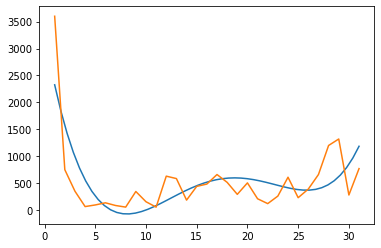

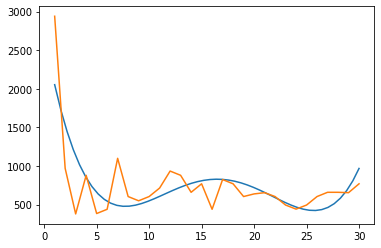

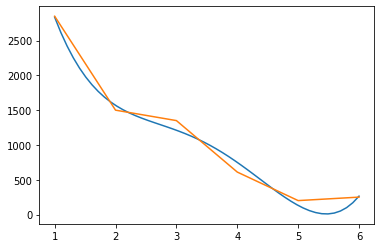

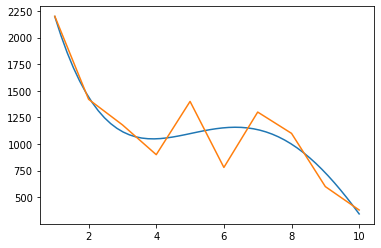

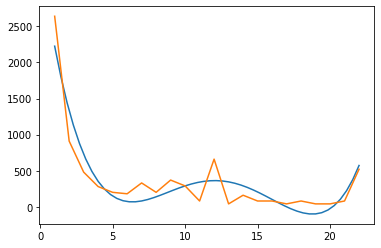

In [399]:
for i in range(0,5):
    pay_coeff = np.polyfit(range(1,len(train.PaymentsHistory[i])+1),train.PaymentsHistory[i],4)
    poly = np.poly1d(pay_coeff)

    plt.plot(np.linspace(1,len(train.PaymentsHistory[i])), poly(np.linspace(1,len(train.PaymentsHistory[i]))))
    plt.plot(range(1,len(train.PaymentsHistory[i])+1),train.PaymentsHistory[i])
    plt.show()

In [400]:
pay_coeff

array([ 2.50816451e-01, -1.24386212e+01,  2.11904680e+02, -1.44400632e+03,
        3.46941934e+03])

In [401]:
coeff_data1 = pd.DataFrame(columns=['p4','p3','p2','p1','p0'],index=range(0,len(train)))
coefficients1 = []
for i in train.PaymentsHistory:
    coefficients1.append(np.polyfit(range(1,len(i)+1),i,4))

In [402]:
for i in range(0,len(train)):
    coeff_data1.iloc[i,:] = coefficients1[i]

In [403]:
train_merged = train_merged.merge(coeff_data1, on=train.index)
train_merged['mean_payment'] = train_merged.PaymentsHistory.apply(lambda x: np.mean(x))
train_merged.drop(columns=['key_0', 'TransactionDates', 'PaymentsHistory'], inplace=True)

In [404]:
train_merged.drop(columns=['m1','m2','m3','m4','m5','m6'], inplace=True)

In [405]:
train_merged.drop(columns=['ID'], inplace=True)

In [406]:
scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(train_merged))
scaled_train.columns = train_merged.columns

In [407]:
scaled_train

,mean_payment,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,expected_time,observed_time,occupation,region,p4,p3,p2,p1,p0
0,-1.058771,0.361451,-0.145782,0.089699,-0.477311,-0.775858,-0.052007,1.181953,0.995192,1.188533,1.255575,2.607087,-2.341650,-0.259315,0.328534,-0.418224,0.487596,-0.519948
1,0.145860,-0.831924,-0.145782,-0.168293,0.721536,1.288895,0.723883,-0.398384,-0.629729,-0.400473,-0.957276,2.607087,-2.341650,-0.259558,0.330244,-0.429209,0.546540,-0.658403
2,-0.405060,-0.831924,-0.145782,-0.168293,0.721536,-0.775858,0.544387,-0.398384,-0.629729,-0.400473,0.390889,2.607087,-2.341650,0.727853,-0.731630,0.663423,-0.546771,0.403428
3,0.790833,0.361451,-0.145782,0.089699,-0.477311,-0.775858,-0.052007,1.181953,0.995192,1.180299,-0.194866,2.607087,-2.341650,-0.228292,0.258285,-0.292262,0.350369,-0.443776
4,0.566530,1.552439,-0.145782,0.089699,-0.477311,1.288895,0.098885,1.107875,0.995586,1.106201,-0.070896,2.607087,-2.341650,-0.254794,0.314124,-0.380114,0.415913,-0.473881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28002,0.343281,1.552439,-0.145782,0.089699,-0.477311,-0.775858,-0.353094,1.107875,0.995586,1.106201,0.530354,0.780696,-0.493524,-0.183000,0.145752,-0.018466,-0.257455,0.786931
28003,0.028031,-0.831924,-0.145782,-0.168293,-0.477311,-0.775858,-1.340323,-1.172090,-0.999566,-1.174393,-0.836406,0.780696,-0.493524,-0.071137,-0.031611,0.201989,-0.402970,0.453734
28004,-0.128064,-0.831924,-0.145782,-0.168293,0.721536,-0.775858,0.275143,-0.398384,-0.629729,-0.392240,-0.201064,0.780696,-0.493524,-0.256456,0.279667,-0.259363,0.170006,-0.145840
28005,-0.190596,-0.831924,-0.145782,-0.168293,0.721536,-0.775858,-0.801834,-0.398384,-0.629729,-0.400473,-0.517186,0.780696,-0.493524,-0.229390,0.261158,-0.303039,0.387732,-0.546720


In [408]:
xgb = XGBRegressor(n_estimators=150, max_depth=2,n_jobs=10,random_state=0)
wrapper = RegressorChain(xgb,order=[0,1,2,3,4,5],random_state=0)

In [409]:
wrapper_model = wrapper.fit(scaled_train, coeff_data)

[22:51:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [410]:
occupation_keys

,Occupation,occupation
2,Farmer,0
4,Labourer,1
0,Business,2
1,Driver/Motorbike Rider,3
5,Other,4
3,Government Employee,5
6,Teacher,6


In [411]:
metadata.Region_y.value_counts()

Nyanza        23766
South Rift    11747
North Rift     1830
Name: Region_y, dtype: int64

In [412]:
region_keys

,Region_y,region
0,North Rift,0
1,Nyanza,1
2,South Rift,2


In [413]:
metadata_z = metadata.merge(occupation_keys, on='Occupation').drop(columns=['Occupation'])

In [414]:
metadata_z = metadata_z.merge(region_keys, on='Region_y').drop(columns=['Region_y'])

In [415]:
test = pd.read_csv(r'C:\Users\Krutarth\Desktop\Datasets\zindi_solarprice\Test.csv')

In [416]:
test.head()

,ID,TransactionDates,PaymentsHistory
0,ID_6L67PAA,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]"
1,ID_VJ80SX2,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ..."
2,ID_7OU9HLK,"['12-2015', '01-2016', '03-2016', '05-2016', '...","[2400.0, 300.0, 500.0, 450.0, 675.0, 700.0, 87..."
3,ID_WVWTPGK,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4700.0, 1200.0, 950.0, 1200.0, 900.0, 1110.0,..."
4,ID_04DSDQS,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4800.0, 750.0, 995.0, 995.0, 1300.0, 750.0, 1..."


In [417]:
test.PaymentsHistory[1]

'[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, 1000.0]'

In [418]:
[float(x.strip().replace("'",'').replace('[','').replace(']','')) for x in test.PaymentsHistory[1].split(',')]

[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, 1000.0]

In [419]:
for i in range(0,len(test)):
    test.TransactionDates[i] = [x.strip().replace("'",'').replace('[','').replace(']','') for x in test.TransactionDates[i].split(',')] 

for i in range(0,len(test)):
    test.PaymentsHistory[i] = [float(x.strip().replace("'",'').replace('[','').replace(']','')) for x in test.PaymentsHistory[i].split(',')]

In [420]:
test.head()

,ID,TransactionDates,PaymentsHistory
0,ID_6L67PAA,"[12-2015, 01-2016, 02-2016, 03-2016, 05-2016, ...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]"
1,ID_VJ80SX2,"[12-2015, 01-2016, 02-2016, 03-2016, 04-2016, ...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ..."
2,ID_7OU9HLK,"[12-2015, 01-2016, 03-2016, 05-2016, 11-2016, ...","[2400.0, 300.0, 500.0, 450.0, 675.0, 700.0, 87..."
3,ID_WVWTPGK,"[12-2015, 01-2016, 02-2016, 03-2016, 04-2016, ...","[4700.0, 1200.0, 950.0, 1200.0, 900.0, 1110.0,..."
4,ID_04DSDQS,"[12-2015, 01-2016, 02-2016, 03-2016, 04-2016, ...","[4800.0, 750.0, 995.0, 995.0, 1300.0, 750.0, 1..."


In [421]:
test.drop(columns=['TransactionDates'], inplace=True)

In [422]:
test['mean_payment'] = test.PaymentsHistory.apply(lambda x: np.mean(x))

In [423]:
test_merged = test.merge(metadata_z, on='ID')

In [424]:
test_merged.head()

,ID,PaymentsHistory,mean_payment,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,expected_time,observed_time,occupation,region
0,ID_6L67PAA,"[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]",1433.333333,2000,0.0,35,7,0,33.000000,364,14740.0,363,1628,4,1
1,ID_VJ80SX2,"[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ...",1285.714286,2000,0.0,35,7,1,40.036088,364,14740.0,363,363,2,1
2,ID_7OU9HLK,"[2400.0, 300.0, 500.0, 450.0, 675.0, 700.0, 87...",759.375000,2000,0.0,35,7,0,32.000000,364,14740.0,363,1689,2,1
3,ID_WVWTPGK,"[4700.0, 1200.0, 950.0, 1200.0, 900.0, 1110.0,...",1266.250000,2000,0.0,35,7,1,42.000000,364,14740.0,364,529,4,1
4,ID_04DSDQS,"[4800.0, 750.0, 995.0, 995.0, 1300.0, 750.0, 1...",1287.777778,2000,0.0,35,7,1,38.000000,364,14740.0,363,428,4,1


In [425]:
coeff_dat2 = pd.DataFrame(columns=['q4','q3','q2','q1','q0'],index=range(0,len(test)))
coefficients2 = []
for i in test.PaymentsHistory:
    coefficients2.append(np.polyfit(range(1,len(i)+1),i,4))
for i in range(0,len(test)):
    coeff_dat2.iloc[i,:] = coefficients2[i]

In [426]:
test_merged = test_merged.merge(coeff_dat2, on=test_merged.index)

In [427]:
test_merged.drop(columns=['PaymentsHistory', 'key_0'], inplace=True)

In [428]:
test_merged.drop(columns=['ID'], inplace=True)

In [429]:
test_merged

,mean_payment,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,expected_time,observed_time,occupation,region,q4,q3,q2,q1,q0
0,1433.333333,2000,0.0,35,7,0,33.000000,364,14740.0,363,1628,4,1,47.9167,-837.5,5152.08,-13176.8,12800
1,1285.714286,2000,0.0,35,7,1,40.036088,364,14740.0,363,363,2,1,29.1667,-530.556,3404.17,-8975.4,9042.86
2,759.375000,2000,0.0,35,7,0,32.000000,364,14740.0,363,1689,2,1,8.78314,-209.927,1713.94,-5535.8,6342.41
3,1266.250000,2000,0.0,35,7,1,42.000000,364,14740.0,364,529,4,1,3.84743,-117.304,1240.33,-5293.49,8497.92
4,1287.777778,2000,0.0,35,7,1,38.000000,364,14740.0,363,428,4,1,18.9714,-426.828,3337.59,-10593.3,12279.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,866.000000,2400,0.0,50,3,0,33.000000,240,14400.0,239,459,0,2,7.04108,-163.927,1331.85,-4425.21,5679.17
9332,1166.666667,2400,0.0,50,3,0,36.000000,240,14400.0,239,460,4,1,1.47727,-52.4158,588.169,-2646.27,5049.44
9333,620.000000,2400,0.0,50,3,0,26.000000,240,14400.0,239,449,0,2,4.78584,-123.733,1126.17,-4194.55,5637.5
9334,755.000000,2400,0.0,50,3,0,26.000000,240,14400.0,239,460,2,1,9.56439,-230.551,1902.19,-6223.6,7262.5


In [430]:
test_col = test_merged.columns
test_scaled = pd.DataFrame(scaler.transform(test_merged))
test_scaled.columns = test_col

In [431]:
predicted_coeff = pd.DataFrame(wrapper_model.predict(test_scaled))

In [432]:
future_val = pd.DataFrame(columns=['Target'],index=range(len(predicted_coeff)*6))
future_list = []
for x in range(len(predicted_coeff)):
    func = np.poly1d(np.array(predicted_coeff.iloc[x,:]))
    for i in range(1,7):
        future_list.append(func(i))        

In [433]:
future_val['Target'] = future_list

In [434]:
Id = test.ID

In [435]:
Id = pd.DataFrame(Id)
Id = pd.concat([Id]*6).sort_index().reset_index(drop=True)

In [436]:
for i in range(len(Id)):
    x+=1
    if x<7:
        Id.iloc[i] = Id.iloc[i]+' '+'x'+' '+'m'+str(x)
    else:
        x=1
        Id.iloc[i] = Id.iloc[i]+' '+'x'+' '+'m'+str(x)

In [437]:
future_val['ID'] = Id

In [438]:
cd C:\Users\Krutarth\Desktop\Datasets\zindi_solarprice

C:\Users\Krutarth\Desktop\Datasets\zindi_solarprice


In [439]:
future_val = future_val[['ID', 'Target']]
future_val.to_csv('submission.csv', index=False)

In [440]:
future_val

,ID,Target
0,ID_6L67PAA x m1,862.389979
1,ID_6L67PAA x m2,1048.105301
2,ID_6L67PAA x m3,1739.315818
3,ID_6L67PAA x m4,3120.638550
4,ID_6L67PAA x m5,5688.341824
...,...,...
56011,ID_WKQPWF3 x m2,3.479691
56012,ID_WKQPWF3 x m3,-929.689679
56013,ID_WKQPWF3 x m4,-2926.632202
56014,ID_WKQPWF3 x m5,-6946.596344
